# 프로젝트: ResNet Ablation Study

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

## ResNet-34만 구현

In [2]:
def build_resnet_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    stage=1
                   ):

    # 입력 레이어
    x = input_layer
    
    # CNN 레이어
    for cnn_num in range(num_cnn):
        if (stage != 0) & (cnn_num == 0):
            strides = (2,2)
        else:
            strides = (1,1)
        
        short = x
        x = keras.layers.Conv2D(channel, kernel_size=(3,3), kernel_initializer='he_normal', padding='same',
                               strides=strides, name = f'stage{stage+2}_{cnn_num+1}_conv{1}')(x)
        x = keras.layers.BatchNormalization(name = f'stage{stage+2}_{cnn_num+1}_bn{1}')(x)
        x = keras.layers.Activation('relu', name = f'stage{stage+2}_{cnn_num+1}_out{1}')(x)
        x = keras.layers.Conv2D(channel, kernel_size=(3,3), kernel_initializer='he_normal', padding='same',
                               name = f'stage{stage+2}_{cnn_num+1}_conv{2}')(x)
        x = keras.layers.BatchNormalization(name = f'stage{stage+2}_{cnn_num+1}_bn{2}')(x)
        short = keras.layers.Conv2D(channel, kernel_size=(1,1), kernel_initializer='he_normal', padding='same',
                                   strides=strides, name = f'stage{stage+2}_{cnn_num+1}_short')(short)
        short = keras.layers.BatchNormalization(name = f'stage{stage+2}_{cnn_num+1}_bn_short')(short)
        x = keras.layers.add([x, short], name = f'stage{stage+2}_{cnn_num+1}_add')
        x = keras.layers.Activation('relu',name = f'stage{stage+2}_{cnn_num+1}_out{2}')(x)

    return x

In [3]:
def build_resnet(input_shape=(32,32,3),
                num_cnn_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=10
                ):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer

    output = keras.layers.Conv2D(64, kernel_size=(7,7), kernel_initializer='he_normal', padding='same', strides=(2,2),
                                 name='stage1_conv')(output)
    output = keras.layers.BatchNormalization(name='stage1_bn')(output)
    output = keras.layers.Activation('relu', name='stage1_out')(output)
    output = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='stage2_0_maxpooling')(output)

    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn,
            channel=channel,
            stage=i
        )
        
    output = keras.layers.AveragePooling2D(pool_size=(1, 1), name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [4]:
resnet_34 = build_resnet(input_shape=(32, 32, 3))
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_conv (Conv2D)            (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
stage1_bn (BatchNormalization)  (None, 16, 16, 64)   256         stage1_conv[0][0]                
__________________________________________________________________________________________________
stage1_out (Activation)         (None, 16, 16, 64)   0           stage1_bn[0][0]                  
______________________________________________________________________________________________

## configuration(is_50) 추가를 통한 ResNet-50 구현

In [5]:
def build_resnet_block(input_layer,
                        num_cnn=3, 
                        channel=64,
                        stage=1,
                        is_50=False
                   ):

    # 입력 레이어
    x = input_layer
    
    # CNN 레이어
    for cnn_num in range(num_cnn):
        if (stage != 0) & (cnn_num == 0):
            strides = (2,2)
        else:
            strides = (1,1)
        
        if is_50 == False:
            short = x
            x = keras.layers.Conv2D(channel, kernel_size=(3,3), kernel_initializer='he_normal', padding='same',
                                   strides=strides, name = f'stage{stage+2}_{cnn_num+1}_conv1')(x)
            x = keras.layers.BatchNormalization(name = f'stage{stage+2}_{cnn_num+1}_bn1')(x)
            x = keras.layers.Activation('relu', name = f'stage{stage+2}_{cnn_num+1}_relu1')(x)
            x = keras.layers.Conv2D(channel, kernel_size=(3,3), kernel_initializer='he_normal', padding='same',
                                   name = f'stage{stage+2}_{cnn_num+1}_conv2')(x)
            x = keras.layers.BatchNormalization(name = f'stage{stage+2}_{cnn_num+1}_bn2')(x)
            
            short = keras.layers.Conv2D(channel, kernel_size=(1,1), kernel_initializer='he_normal', padding='same',
                                       strides=strides, name = f'stage{stage+2}_{cnn_num+1}_short')(short)
            short = keras.layers.BatchNormalization(name = f'stage{stage+2}_{cnn_num+1}_bn_short')(short)
            
            x = keras.layers.add([x, short], name = f'stage{stage+2}_{cnn_num+1}_add')
            x = keras.layers.Activation('relu', name = f'stage{stage+2}_{cnn_num+1}_relu2')(x)
        
        else:
            short = x
            x = keras.layers.Conv2D(channel, kernel_size=(1,1), kernel_initializer='he_normal',
                                    strides=strides, name = f'stage{stage+2}_{cnn_num+1}_conv1')(x)
            x = keras.layers.BatchNormalization(name = f'stage{stage+2}_{cnn_num+1}_bn1')(x)
            x = keras.layers.Activation('relu', name = f'stage{stage+2}_{cnn_num+1}_relu1')(x)

            x = keras.layers.Conv2D(channel, kernel_size=(3,3), padding='same', kernel_initializer='he_normal',
                                    name = f'stage{stage+2}_{cnn_num+1}_conv2')(x)
            x = keras.layers.BatchNormalization(name = f'stage{stage+2}_{cnn_num+1}_bn2')(x)
            x = keras.layers.Activation('relu', name = f'stage{stage+2}_{cnn_num+1}_relu2')(x)

            x = keras.layers.Conv2D(channel*4, kernel_size=(1,1), kernel_initializer='he_normal',
                                    name = f'stage{stage+2}_{cnn_num+1}_conv3')(x)
            x = keras.layers.BatchNormalization(name = f'stage{stage+2}_{cnn_num+1}_bn3')(x)
            x = keras.layers.Activation('relu', name = f'stage{stage+2}_{cnn_num+1}_relu3')(x)
            
            short = keras.layers.Conv2D(channel*4, kernel_size=(1,1), kernel_initializer='he_normal',
                                        strides=strides, name = f'stage{stage+2}_{cnn_num+1}_short')(short)
            short = keras.layers.BatchNormalization(name = f'stage{stage+2}_{cnn_num+1}_bn_short')(short)
            
            x = keras.layers.add([x, short], name = f'stage{stage+2}_{cnn_num+1}_add')
            x = keras.layers.Activation('relu', name = f'stage{stage+2}_{cnn_num+1}_relu4')(x)

    return x

In [6]:
def build_resnet(input_shape=(32,32,3),
                num_cnn_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=10,
                is_50=False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer

    output = keras.layers.Conv2D(64, kernel_size=(7,7), kernel_initializer='he_normal', padding='same', strides=(2,2),
                                 name='stage1_conv')(output)
    output = keras.layers.BatchNormalization(name='stage1_bn')(output)
    output = keras.layers.Activation('relu', name='stage1_out')(output)
    output = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='stage2_0_maxpooling')(output)

    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn,
            channel=channel,
            stage=i,
            is_50=is_50
        )
        
    output = keras.layers.AveragePooling2D(pool_size=(1, 1), name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [7]:
resnet_50 = build_resnet(input_shape=(32, 32, 3), is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_conv (Conv2D)            (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
stage1_bn (BatchNormalization)  (None, 16, 16, 64)   256         stage1_conv[0][0]                
__________________________________________________________________________________________________
stage1_out (Activation)         (None, 16, 16, 64)   0           stage1_bn[0][0]                  
____________________________________________________________________________________________

## 일반 네트워크 Plain network 만들기

- ResNet의 효과를 보기 위해 skip connection이 없는 일반 네트워크(plainnet)가 필요.
- 위의 ResNet 구현 코드에서 skip connection에 해당하는 부분만 수정하면 된다.
- configuration(is_skip)을 추가해서 skip connection을 설정할 수 있도록 해주었음.
- 입력 이미지의 크기는 (224, 224, 3)으로 설정

In [8]:
def build_plainnet_block(input_layer,
                        num_cnn=3, 
                        channel=64,
                        stage=1,
                        is_50=False,
                        is_skip=False
                   ):

    # 입력 레이어
    x = input_layer
    
    # CNN 레이어
    for cnn_num in range(num_cnn):
        if (stage != 0) & (cnn_num == 0):
            strides = (2,2)
        else:
            strides = (1,1)
        
        if is_50 == False:
            short = x
            x = keras.layers.Conv2D(channel, kernel_size=(3,3), kernel_initializer='he_normal', padding='same',
                                   strides=strides, name = f'stage{stage+2}_{cnn_num+1}_conv1')(x)
            x = keras.layers.BatchNormalization(name = f'stage{stage+2}_{cnn_num+1}_bn1')(x)
            x = keras.layers.Activation('relu', name = f'stage{stage+2}_{cnn_num+1}_relu1')(x)
            x = keras.layers.Conv2D(channel, kernel_size=(3,3), kernel_initializer='he_normal', padding='same',
                                   name = f'stage{stage+2}_{cnn_num+1}_conv2')(x)
            x = keras.layers.BatchNormalization(name = f'stage{stage+2}_{cnn_num+1}_bn2')(x)
            
            if is_skip == False:
                short = keras.layers.Conv2D(channel, kernel_size=(1,1), kernel_initializer='he_normal', padding='same',
                                           strides=strides, name = f'stage{stage+2}_{cnn_num+1}_short')(short)
                short = keras.layers.BatchNormalization(name = f'stage{stage+2}_{cnn_num+1}_bn_short')(short)
            
                x = keras.layers.add([x, short], name = f'stage{stage+2}_{cnn_num+1}_add')
            x = keras.layers.Activation('relu', name = f'stage{stage+2}_{cnn_num+1}_relu2')(x)
        
        else:
            short = x
            x = keras.layers.Conv2D(channel, kernel_size=(1,1), kernel_initializer='he_normal',
                                    strides=strides, name = f'stage{stage+2}_{cnn_num+1}_conv1')(x)
            x = keras.layers.BatchNormalization(name = f'stage{stage+2}_{cnn_num+1}_bn1')(x)
            x = keras.layers.Activation('relu', name = f'stage{stage+2}_{cnn_num+1}_relu1')(x)

            x = keras.layers.Conv2D(channel, kernel_size=(3,3), padding='same', kernel_initializer='he_normal',
                                    name = f'stage{stage+2}_{cnn_num+1}_conv2')(x)
            x = keras.layers.BatchNormalization(name = f'stage{stage+2}_{cnn_num+1}_bn2')(x)
            x = keras.layers.Activation('relu', name = f'stage{stage+2}_{cnn_num+1}_relu2')(x)

            x = keras.layers.Conv2D(channel*4, kernel_size=(1,1), kernel_initializer='he_normal',
                                    name = f'stage{stage+2}_{cnn_num+1}_conv3')(x)
            x = keras.layers.BatchNormalization(name = f'stage{stage+2}_{cnn_num+1}_bn3')(x)
            x = keras.layers.Activation('relu', name = f'stage{stage+2}_{cnn_num+1}_relu3')(x)
            
            if is_skip == False:
                short = keras.layers.Conv2D(channel*4, kernel_size=(1,1), kernel_initializer='he_normal',
                                            strides=strides, name = f'stage{stage+2}_{cnn_num+1}_short')(short)
                short = keras.layers.BatchNormalization(name = f'stage{stage+2}_{cnn_num+1}_bn_short')(short)
            
                x = keras.layers.add([x, short], name = f'stage{stage+2}_{cnn_num+1}_add')
            x = keras.layers.Activation('relu', name = f'stage{stage+2}_{cnn_num+1}_relu4')(x)

    return x

In [9]:
def build_plainnet(input_shape=(32,32,3),
                num_cnn_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=5,
                is_50=False,
                is_skip=False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer

    output = keras.layers.Conv2D(64, kernel_size=(7,7), kernel_initializer='he_normal', padding='same', strides=(2,2),
                                 name='stage1_conv')(output)
    output = keras.layers.BatchNormalization(name='stage1_bn')(output)
    output = keras.layers.Activation('relu', name='stage1_out')(output)
    output = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='stage2_0_maxpooling')(output)

    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_plainnet_block(
            output,
            num_cnn=num_cnn,
            channel=channel,
            stage=i,
            is_50=is_50,
            is_skip=is_skip
        )
        
    output = keras.layers.AveragePooling2D(pool_size=(1, 1), name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

- 입력 이미지 크기가 (224,224,3)인 ResNet-34, 50,  Plain-34, 50 모델들을 다시 만들기

In [10]:
resnet_34 = build_plainnet(input_shape=(224, 224, 3), is_50=False, is_skip=False)
resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_conv (Conv2D)            (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
stage1_bn (BatchNormalization)  (None, 112, 112, 64) 256         stage1_conv[0][0]                
__________________________________________________________________________________________________
stage1_out (Activation)         (None, 112, 112, 64) 0           stage1_bn[0][0]                  
____________________________________________________________________________________________

In [11]:
resnet_50 = build_plainnet(input_shape=(224, 224, 3), is_50=True, is_skip=False)
resnet_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_conv (Conv2D)            (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
stage1_bn (BatchNormalization)  (None, 112, 112, 64) 256         stage1_conv[0][0]                
__________________________________________________________________________________________________
stage1_out (Activation)         (None, 112, 112, 64) 0           stage1_bn[0][0]                  
____________________________________________________________________________________________

In [12]:
plainnet_34 = build_plainnet(input_shape=(224, 224, 3), is_50=False, is_skip=True)
plainnet_34.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_conv (Conv2D)         (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_bn (BatchNormalizatio (None, 112, 112, 64)      256       
_________________________________________________________________
stage1_out (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

In [13]:
plainnet_50 = build_plainnet(input_shape=(224, 224, 3), is_50=True, is_skip=True)
plainnet_50.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_conv (Conv2D)         (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_bn (BatchNormalizatio (None, 112, 112, 64)      256       
_________________________________________________________________
stage1_out (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

## 데이터셋 준비
- tf_flowers 데이터셋을 사용

In [14]:
(ds_train, ds_test), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [15]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})


In [16]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(2936, shape=(), dtype=int64)
tf.Tensor(734, shape=(), dtype=int64)


In [17]:
ds_info.features["label"].names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [18]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})

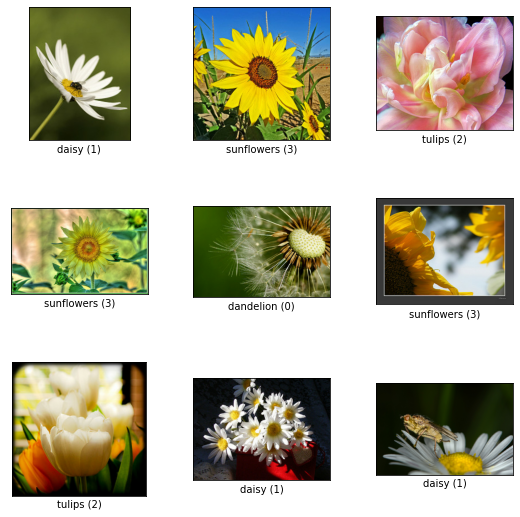

In [19]:
fig = tfds.show_examples(ds_train, ds_info)

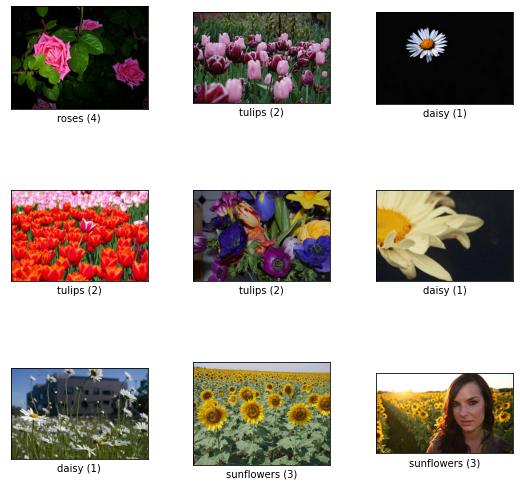

In [20]:
fig = tfds.show_examples(ds_test, ds_info)

In [21]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224, 224))
    return tf.cast(image, tf.float32) / 255., label

In [22]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 모델 훈련

In [23]:
BATCH_SIZE = 16
EPOCH = 50

In [24]:
(ds_train, ds_test), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [25]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
183/183 [==============================] - 45s 143ms/step - loss: 1.9222 - accuracy: 0.2658 - val_loss: 1.8820 - val_accuracy: 0.2388
Epoch 2/50
183/183 [==============================] - 23s 128ms/step - loss: 1.8463 - accuracy: 0.2993 - val_loss: 1.8884 - val_accuracy: 0.2674
Epoch 3/50
183/183 [==============================] - 24s 130ms/step - loss: 1.7683 - accuracy: 0.3193 - val_loss: 2.4161 - val_accuracy: 0.2346
Epoch 4/50
183/183 [==============================] - 24s 131ms/step - loss: 1.7005 - accuracy: 0.3541 - val_loss: 1.9580 - val_accuracy: 0.3333
Epoch 5/50
183/183 [==============================] - 24s 133ms/step - loss: 1.6656 - accuracy: 0.3630 - val_loss: 1.7566 - val_accuracy: 0.3733
Epoch 6/50
183/183 [==============================] - 25s 134ms/step - loss: 1.5386 - accuracy: 0.3973 - val_loss: 2.8483 - val_accuracy: 0.3611
Epoch 7/50
183/183 [==============================] - 25s 136ms/step - loss: 1.4801 - accuracy: 0.4109 - val_loss: 1.4803 - val_ac

In [26]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
183/183 [==============================] - 75s 335ms/step - loss: 1.9810 - accuracy: 0.2853 - val_loss: 1.9165 - val_accuracy: 0.2145
Epoch 2/50
183/183 [==============================] - 58s 316ms/step - loss: 1.8727 - accuracy: 0.3186 - val_loss: 1.7042 - val_accuracy: 0.3106
Epoch 3/50
183/183 [==============================] - 57s 314ms/step - loss: 1.8703 - accuracy: 0.3298 - val_loss: 2.1246 - val_accuracy: 0.3639
Epoch 4/50
183/183 [==============================] - 58s 315ms/step - loss: 1.7893 - accuracy: 0.3445 - val_loss: 2.2940 - val_accuracy: 0.3524
Epoch 5/50
183/183 [==============================] - 58s 315ms/step - loss: 1.6804 - accuracy: 0.3777 - val_loss: 2.7763 - val_accuracy: 0.2869
Epoch 6/50
183/183 [==============================] - 58s 315ms/step - loss: 1.6849 - accuracy: 0.3777 - val_loss: 2.1711 - val_accuracy: 0.3440
Epoch 7/50
183/183 [==============================] - 58s 316ms/step - loss: 1.6806 - accuracy: 0.3699 - val_loss: 2.3117 - val_ac

In [29]:
plainnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plainnet_34 = plainnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
183/183 [==============================] - 28s 114ms/step - loss: 1.7148 - accuracy: 0.2917 - val_loss: 1.8222 - val_accuracy: 0.2340
Epoch 2/50
183/183 [==============================] - 21s 113ms/step - loss: 1.6765 - accuracy: 0.3168 - val_loss: 1.7112 - val_accuracy: 0.2911
Epoch 3/50
183/183 [==============================] - 21s 114ms/step - loss: 1.6691 - accuracy: 0.3267 - val_loss: 1.8275 - val_accuracy: 0.2875
Epoch 4/50
183/183 [==============================] - 21s 115ms/step - loss: 1.6773 - accuracy: 0.3137 - val_loss: 2.8183 - val_accuracy: 0.2897
Epoch 5/50
183/183 [==============================] - 21s 117ms/step - loss: 1.6158 - accuracy: 0.3493 - val_loss: 1.9980 - val_accuracy: 0.3412
Epoch 6/50
183/183 [==============================] - 22s 118ms/step - loss: 1.5642 - accuracy: 0.3657 - val_loss: 1.9492 - val_accuracy: 0.3347
Epoch 7/50
183/183 [==============================] - 22s 118ms/step - loss: 1.5529 - accuracy: 0.3699 - val_loss: 2.6219 - val_ac

In [30]:
plainnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plainnet_50 = plainnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
183/183 [==============================] - 42s 181ms/step - loss: 1.7963 - accuracy: 0.2579 - val_loss: 2.0111 - val_accuracy: 0.1969
Epoch 2/50
183/183 [==============================] - 32s 175ms/step - loss: 1.7767 - accuracy: 0.2747 - val_loss: 1.7054 - val_accuracy: 0.2542
Epoch 3/50
183/183 [==============================] - 32s 175ms/step - loss: 1.7816 - accuracy: 0.2736 - val_loss: 1.9912 - val_accuracy: 0.2570
Epoch 4/50
183/183 [==============================] - 32s 175ms/step - loss: 1.7586 - accuracy: 0.2940 - val_loss: 2.7101 - val_accuracy: 0.2919
Epoch 5/50
183/183 [==============================] - 32s 176ms/step - loss: 1.7815 - accuracy: 0.2886 - val_loss: 2.8556 - val_accuracy: 0.2833
Epoch 6/50
183/183 [==============================] - 32s 176ms/step - loss: 1.7553 - accuracy: 0.2995 - val_loss: 5.9761 - val_accuracy: 0.2292
Epoch 7/50
183/183 [==============================] - 32s 176ms/step - loss: 1.7612 - accuracy: 0.2885 - val_loss: 2.8484 - val_ac

### ResNet-34 vs PlainNet-34

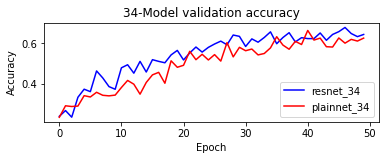

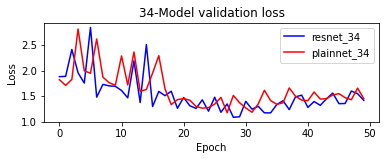

In [48]:
plt.subplot(2,1,1)
plt.plot(history_resnet_34.history['val_accuracy'], 'b')
plt.plot(history_plainnet_34.history['val_accuracy'], 'r')
plt.title('34-Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'], loc='lower right')
plt.show()

plt.subplot(2,1,2)
plt.plot(history_resnet_34.history['val_loss'], 'b')
plt.plot(history_plainnet_34.history['val_loss'], 'r')
plt.title('34-Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'])
plt.show()

- 엇비슷하긴 하지만, resnet-34가 accuracy가 살짝 더 높고, loss가 살짝 더 낮은걸로 보인다.

### ResNet-50 vs PlainNet-50

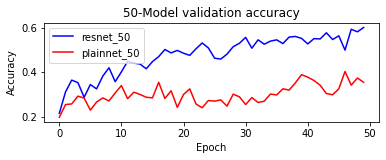

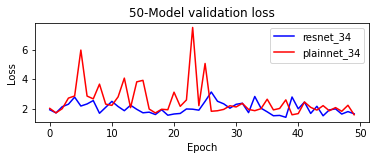

In [54]:
plt.subplot(2,1,1)
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.plot(history_plainnet_50.history['val_accuracy'], 'r')
plt.title('50-Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plainnet_50'])
plt.show()

plt.subplot(2,1,2)
plt.plot(history_resnet_50.history['val_loss'], 'b')
plt.plot(history_plainnet_50.history['val_loss'], 'r')
plt.title('50-Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'])
plt.show()

- 34 모델과는 다르게 확실히 둘의 차이가 눈에 띈다.
- resnet-50이 accuracy도 그렇고 loss도 그렇고, 더 나은 성능을 보인다.

# 회고
- 첫번째 고비, 모델 만들기 진짜, 정말, 어려웠다. 시작하려는데 엄두도 안났었다.
- 결과 예시 보면서 한줄한줄씩 쭉 써봤고, 거기서 반복되는 구간을 찾아서 그 구간을 함수로 어떻게든 만들어봤다.
- 두번째 고비, 모델 훈련시키려고 하는데 자꾸 커널이 죽었다.
- 처음엔 cat_vs_dog 데이터셋으로 진행했었는데, 밑에 corrupted image~~~ 하는 경고가 나오길래, 그것때문에 커널이 죽는걸까? 생각해봤고
- 그래서 다른 데이터셋을 찾아봤다.
- 적당한 데이터셋 ts_flowers를 찾아서 진행해봤다.
- corrupted image 경고는 안나오는데, 그래도 커널이 죽었다.
- 하루종일 어떻게 해야하나 고민해보고 있었는데, 커널이 죽는 이유를 찾아보니 메모리가 너무 커서 그렇다고 나왔다.
- 메모리,, 훈련시킬때 한번에 너무 많은 이미지를 봐서 그런걸까 싶었다.
- 배치사이즈를 줄여서 해보자 해서 배치사이즈를 256에서 32로 확 줄여서 진행해봤다.
- 32 모델들은 잘 훈련이 됐는데 50 모델들을 훈련시키니 또 커널이 죽었다.
- 그래서 최종적으로 배치사이즈를 16으로 잡고, 대신 에폭을 늘려서 50번을 돌렸다.
- 그 결과 위의 결과가 나왔다....
- 모델 만드는것도 그렇고, 커널 죽는것도 그렇고 어떻게든 해결을 하긴 했는데, 이렇게 하는게 맞는걸까? 이렇게 해도 되는걸까? 싶다.
- 그래도 해결해서 뿌듯하다!!!